In [1]:
from sklearn.datasets import fetch_olivetti_faces
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf
import os

faces = fetch_olivetti_faces(shuffle=True, random_state=1000)
x_train, x_test = faces['images'][0:200], faces['images'][200:]
y_train, y_test = faces['target'][0:200], faces['target'][0:200]
x_train.shape, x_test.shape
#print(faces.DESCR)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/91425289/scikit_learn_data


((200, 64, 64), (200, 64, 64))

In [2]:
image_size = x_train.shape[1] #64 x 64
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32')  
x_test = x_test.astype('float32')  

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 200

In [3]:
original_dim

4096

In [3]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    

In [5]:
### edTest(test_sampling) ###

# build encoder model
inputs = tf.keras.layers.Input(shape=input_shape, name='encoder_input')

x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# Create a Lambda layer that wraps "sampling" (defined above).
# Remember to connect [z_mean, z_log_var] with this layer.  
# You may add latent_dim as output_shape and name ='z'
# 
z = tf.keras.layers.Lambda(lambda x: sampling(x),output_shape = (latent_dim,), 
                           name = 'z')([z_mean, z_log_var])

# instantiate encoder model
encoder = tf.keras.models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 4096)]       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          2097664     encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
____________________________________________________________________________________________

In [6]:
# build decoder model
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,), name='z_sampling')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = tf.keras.layers.Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = tf.keras.models.Model(latent_inputs, outputs, name='decoder')
#decoder.summary()
 
# VAE model = encoder + decoder
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.models.Model(inputs, outputs, name='vae')
 

reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5

#Define vae_loss as mean of (reconstruction loss + KL loss)
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 4096)]       0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 2099716     encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 (None, 4096)         2102784     encoder[1][2]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          2097664     encoder_input[0][0]              
________________________________________________________________________________________________

In [7]:
### edTest(test_vae_loss) ###
history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None), verbose=0)


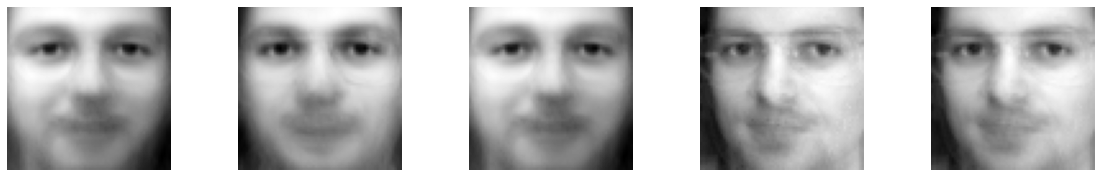

In [8]:
n_img = 5
x_val = x_test    
xr_vae1 = vae.predict(x_val)

fig, ax = plt.subplots(1, n_img, figsize=(20, 3))

for i in range(n_img):
    ax[i].axis('off')
    ax[i].imshow(np.clip(xr_vae1[i].reshape(64,64), 0.0, 1.0),cmap='gray')
    